#Biweekly Report 4

##Logan Barnhart

This week I'll be implementing my own methods for mixup, random erasing, and cutmix. I start by creating each method to directly modify two images, then show the steps that are necessary to create a pipeline for using one of the augmentation techniques to train a model. 

I referenced the following articles very loosely and tried to implement the functions just on my own and with our course notes - I only referenced these primarily for syntax related issues that arose. 

building pipeline for these data augmenting funcs: https://keras.io/examples/vision/mixup/

where I found the .assign method: https://github.com/uranusx86/Random-Erasing-tensorflow/blob/master/random_erasing.py

In [2]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

Let's load in a dataset and take a quick look - I'll be using the horses or humans dataset because why not!

In [ ]:
ds, info = tfds.load("horses_or_humans", split = ["train", "test"],  as_supervised=True, with_info=True)

In [4]:
print(info.features['label'].num_classes)
print(info.splits['train'].num_examples)
print(info.splits['test'].num_examples)

2
1027
256


Not really important for this notebook but we can see that the dataset is composed of 2 classes, the training set has 1027 examples, and the test set has 256 examples. Definitely a dataset you'd want to apply extensive data augmentation to to increase the number of samples. 

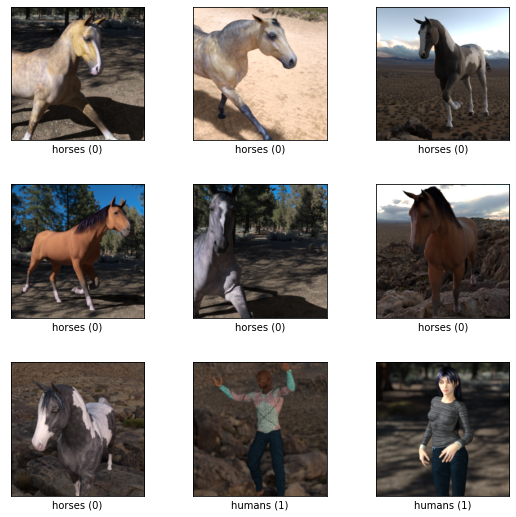

In [5]:
fig = tfds.visualization.show_examples(ds[0], info)

In [6]:
ds_train = ds[0].batch(2) # batch size = 2 to get 2 images at a time for testing
iterator = iter(ds_train)
get_label_name = info.features['label'].int2str # function to produce label as a string from its integer value

Okay, let's take a quick look at the example images we'll be augmenting:

Text(0.5, 1.0, 'humans')

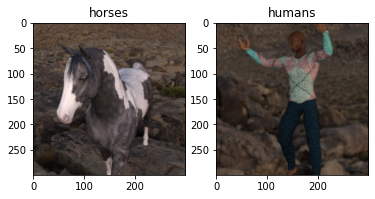

In [38]:
imgs, labels = iterator.next()
fig, ax = plt.subplots(1, 2)
ax[0].imshow(imgs[0])
ax[0].set_title(get_label_name(labels[0]))
ax[1].imshow(imgs[1])
ax[1].set_title(get_label_name(labels[1]))

In [254]:
print(imgs[0].dtype)

<dtype: 'uint8'>


For mixup we have to multiply all the values in each tensor by a float, but they're currently int types - with how multiplying tensors by scalars works in tensorflow this will lead to pesky errors of non matching types, so we'll have to normalize them to convert them to floats (plus we'd want to normalize them anyways if we were training a model with them).

In [255]:
normalize = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255), # rescale RGB values to [0,1]
])

##Mixup

In [256]:
def mixup(img1, img2, lab1, lab2, scale, num_classes):
  #normalize the images
  n_img1 = normalize(img1)
  n_img2 = normalize(img2)
  #combine the images after scaling them
  img = tf.math.scalar_mul(scale, n_img1) + tf.math.scalar_mul((1-scale), n_img2)
  #convert labels to 1-hot vectors
  lab1_1hot = tf.one_hot(lab1, num_classes)
  lab2_1hot = tf.one_hot(lab2, num_classes)
  #combine labels
  label = tf.math.scalar_mul(scale, lab1_1hot) + tf.math.scalar_mul((1-scale), lab2_1hot)
  return (img, label)

In [41]:
mixedimg, mixedlabel = mixup(imgs[0], imgs[1], labels[0], labels[1], .5, 2)

tf.Tensor([0.5 0.5], shape=(2,), dtype=float32)


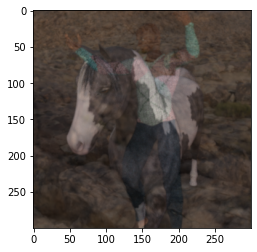

In [43]:
print(mixedlabel)
plt.imshow(mixedimg)

Great! So we can definitely see that the label is half human and half horse... centaur... oh, and the image definitely looks like it's successfully been mixed!

##Random Erase

In [257]:
def random_erase(img, label, prob, erase_low, erase_high, ratio_low, ratio_high):
  #probability our image doesn't get random section erased
  p = np.random.uniform(0,1) 
  if p >= prob: 
    return img, label
  #normalize image
  n_img = tf.Variable(normalize(img)) 
  # isolate image height, weight
  h = n_img.shape[0]
  w = n_img.shape[1]
  while(True):
    #random area to be erased, random aspect ratio. 
    s = np.random.uniform(erase_low, erase_high) * h * w
    r = np.random.uniform(ratio_low, ratio_high)
    #dimensions of area to be erased
    h_erase = int((s * r)**(1/2))
    w_erase = int((s /r)**(1/2))
    #coordinates to erase from
    x = np.random.randint(0, w)
    y = np.random.randint(0, h)
    #repeat until we have valid coordinates, i.e. not going to try and erase out of bounds
    if x + w_erase <= w and y + h_erase <= h:
      #create random noise in the shape of our erased section
      erase = tf.random.uniform((h_erase, w_erase,3))
      #set region of image equal to the random noise
      n_img[y:y + h_erase, x:x + w_erase, :].assign(erase)
      return n_img, label

In [258]:
erased, erased_label = random_erase(imgs[0], labels[0], 1, .1, .2, 0, 1)

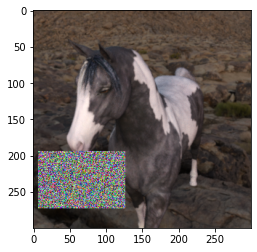

In [259]:
plt.imshow(erased)

Very nice! The cut out area does indeed look like random noise, and it's a valid region to erase from our image.

##Cutmix

In [277]:
def cutmix(img1, img2, lab1, lab2, cut_low, cut_high, ratio_low, ratio_high, num_classes):
  #normalize images and convert labels to 1-hot vectors
  n_img1 = tf.Variable(normalize(img1))
  n_img2 = tf.Variable(normalize(img2))
  lab1_1hot = tf.one_hot(lab1, num_classes)
  lab2_1hot = tf.one_hot(lab2, num_classes)
  #get dimensions of our images
  h = n_img1.shape[0]
  w = n_img1.shape[1]
  while(True):
    #random percentage of area to be cut out
    s = np.random.uniform(cut_low, cut_high) * h * w
    #random aspect ratio
    r = np.random.uniform(ratio_low, ratio_high)
    #dimensions of cutout area
    h_erase = int((s * r)**(1/2))
    w_erase = int((s /r)**(1/2))
    #random coordinates to cut at
    x = np.random.randint(0, w)
    y = np.random.randint(0, h)
    #repeat until we have a valid section to cut
    if x + w_erase <= w and y + h_erase <= h:
      #cutout from our second image at the appropriate region
      cut1 = n_img1[y: y + h_erase, x : x + w_erase,:]
      cut2 = n_img2[y: y + h_erase, x : x + w_erase,:]
      #set first image at the region to the cutout from second image
      n_img1[y:y + h_erase, x:x + w_erase, :].assign(cut2)
      n_img2[y: y + h_erase, x : x + w_erase,:].assign(cut1)
      #update label to have correct percentages of each image
      scale = s / h / w
      label1 = tf.math.scalar_mul(1 - scale, lab1_1hot) + tf.math.scalar_mul(scale, lab2_1hot)
      label2 = tf.math.scalar_mul(1 - scale, lab2_1hot) + tf.math.scalar_mul(scale, lab1_1hot)
      return n_img1, label1, n_img2, label2

In [278]:
cutimg1, cutlabel1, cutimg2, cutlabel2 = cutmix(imgs[0], imgs[1], labels[0], labels[1], .2, .3, 0, 1,2)

tf.Tensor([0.7466032 0.2533968], shape=(2,), dtype=float32)
tf.Tensor([0.2533968 0.7466032], shape=(2,), dtype=float32)


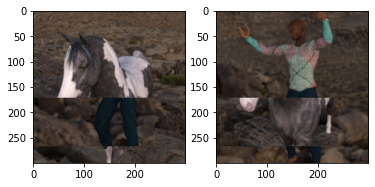

In [279]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(cutimg1)
ax[1].imshow(cutimg2)
print(cutlabel1)
print(cutlabel2)

Perfect, so we can see that the first image indeed has the human legs in there and the second image has the bottom part of the horse in there - thankfully the labels line up and the first image is 75% horse while the second image is 75% human. 

#Building a data pipeline

I'm only going to build a cohesive pipeline for mixup because it's the simplest to implement and results in a method where you don't need a frightening amount of iterations or to constrain the batch size to 1 or 2. 

We need to pass two images into the mixup function so we're going to need to make a dataset that is capable of doing that simultaneously. So, we'll create two shuffled copies of our training set:

In [290]:
train1 = ds[0].shuffle(20000)
train2 = ds[0].shuffle(20000)

Like I said, this is the one method where we don't need to constrain the batch size so let's set it to something you might actually use when training a model. 

In [291]:
train1 = train1.batch(64)
train2 = train2.batch(64)

Now I'm just going to check that our two training sets are actually shuffled by comparing the first image of each:

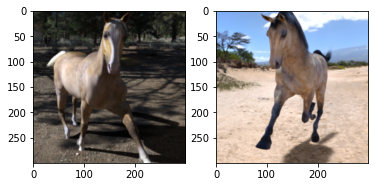

In [292]:
iterator1 = iter(train1)
iterator2 = iter(train2)
imgs1, labels1 = iterator1.next()
imgs2, labels2 = iterator2.next()
fig, ax = plt.subplots(1, 2)
ax[0].imshow(imgs1[0])
ax[1].imshow(imgs2[0])


Great! Now we just have to combine both of them into a single dataset that we can map to our mixup function.

In [293]:
train_ds = tf.data.Dataset.zip((train1, train2))
test_ds = ds[1].batch(64)

## Minor update to methods:
Okay, so we designed our method to take two images and two labels, but you can't exactly do that when training (or you wouldn't always want to). So, we need to update some of our syntax to accomadate entire batches of images. 

In [294]:
def mixup(ds1, ds2, scale, num_classes):
  # separate all images + labels in first batch from first and second dataset
  imgs1, labs1 = ds1
  imgs2, labs2 = ds2
  #cast the images to be floats so we can normalize and scale the entire batch in one step
  imgs1 = tf.cast(imgs1, float)
  imgs2 = tf.cast(imgs2, float)
  #scale and normalize each image, then combine
  imgs = tf.math.scalar_mul(scale / 255, imgs1) + tf.math.scalar_mul((1-scale) / 255, imgs2)
  #convert all labels to 1-hot vectors
  labs1_1hot = tf.one_hot(labs1, num_classes)
  labs2_1hot = tf.one_hot(labs2, num_classes)
  #scale labels and combine
  labels = tf.math.scalar_mul(scale, labs1_1hot) + tf.math.scalar_mul((1-scale), labs2_1hot)
  return (imgs, labels)


So, normalizing the images when they're in a batch won't work if we try and do it how we did earlier. This is because imgs1, and imgs2 have shape (batch_size, height, width, channels) rather than just (height, width, channels). To get around this we can just multiply each value in the tensors by our scaling factor and normalize them at once, it just requires manually convering the data types to floats. 


Now let's map this change to the entire dataset:

In [295]:
train_ds = train_ds.map(lambda ds_one, ds_two: mixup(ds_one, ds_two, np.random.uniform(0,1), 2))

If it worked then each of the following images should be mixed!

In [296]:
sample_images, sample_labels = next(iter(train_ds))

[0.3620778024196625, 0.6379221677780151]
[0.6379221677780151, 0.3620778024196625]
[0.6379221677780151, 0.3620778024196625]
[1.0, 0.0]
[1.0, 0.0]
[0.0, 1.0]
[0.3620778024196625, 0.6379221677780151]
[1.0, 0.0]
[0.0, 1.0]


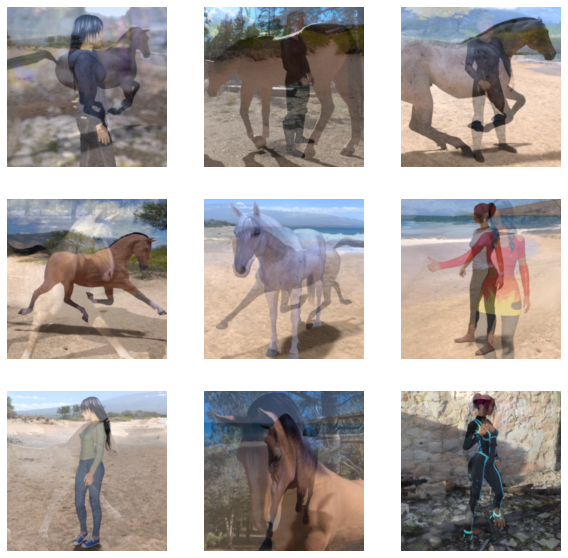

In [297]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().squeeze())
    print(label.numpy().tolist())
    plt.axis("off")

Woohoo! So it seems to have worked! As you can see, some of the labels are still just 100% horse or human. This happens when we use mixup on two images of the same class - I'm not sure if this is to be avoided but it could be easily implemented with a simple if statement. 

##Discussion on the pipelines for the other two methods

Both of the other methods could be implemented one of two ways: 

First we could allow the user to have variable batch size which would require iterating through the code we currently have for each image in a batch since we want a different section of each image cropped or replaced. 

The other way would be to restrict batch size to 1 image and then the implementation would be nearly identical to how we did the pipeline for mixup. 

I *would* make some kind of pipeline for those methods but long story short, it wouldn't be very beneficial or insightful to do so unless I was planning on looking at how the augmentation might affect a model, which... sadly I am not for reasons unrelated to this report! 

## Conclusion

Well, conclusions don't reach beyond much of what we've already seen. It is good to know that implementing these data augmentation techniques really isn't that hard and I'll definitely be re-implementing them when trying to improve models in the future. 

For a future report I would like to explore how these methods would improve a model. 

I'd also like to explore the extent of how much you can mix two sets of images. For example, with mixup and cutmix, we can shuffle the two sets of images and achieve unique sets of mixed images numerous times. How far could we take this and how large could you really make your dataset while still preventing overfitting?

'Till next time!